<h4 style="text-align: right">
*M. Isabel Gonzalez Rosas*
</h4>
***

<h1 style="text-align: center">  Project 4: Analyze A/B Test Results </h1>


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


b. Use the below cell to find the number of rows in the dataset.

In [3]:
rows_count = df.shape[0]
rows_count

294478

c. The number of unique users in the dataset.

In [4]:
unique_users_count = df['user_id'].nunique()
unique_users_count

290584

d. The proportion of users converted.

In [5]:
unique_converted_users = df.query('converted == 1')['user_id'].nunique()
unique_converted_users / unique_users_count

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
new_pageVStreatment_count = df.query('landing_page == "new_page" and group != "treatment" \
or landing_page != "new_page" and group == "treatment"').count()[0]
new_pageVStreatment_count

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

**Rows where `new_page` and `treatment` or `old_page` and `control` are not alligned will be discarded.**

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('landing_page == "new_page" and group == "treatment" \
or landing_page == "old_page" and group == "control"')
df2.shape[0]  == rows_count- new_pageVStreatment_count

True

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
unique_users_count = df2['user_id'].nunique()
unique_users_count

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# https://33sticks.com/python-for-business-identifying-duplicate-data/
df2['is_dup'] = df2.duplicated(['user_id'])
df2.query('is_dup')['user_id']

C:\Users\isa_3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('is_dup')

,user_id,timestamp,group,landing_page,converted,is_dup
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(df2.index[2893])
df2 = df2.drop('is_dup', axis=1)# I created this column just to get the row's information

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

$$P(converting)$$

In [14]:
p_converting = df2.query('converted == 1').shape[0] / unique_users_count
p_converting

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_count = df2.query('group == "control"').shape[0]
converted_and_control_count = df2.query('group == "control" and converted==1').shape[0] 
converted_when_control = converted_and_control_count /  control_count
converted_when_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_count = df2.query('group == "treatment"').shape[0]
converted_and_treatment_count = df2.query('group == "treatment" and converted==1').shape[0] 
converted_when_treatment = converted_and_treatment_count /  treatment_count
converted_when_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Although results show convertion rate is bigger for control group, there is yet not sufficient evidence to support one or another hypothesis since the sample results may have happened by chance and may not represent the population's real rate.  <p>
In this case, a bootstrapping sample and, either confidence intervals or hypothesis testing, can help choose between new or old page.** 

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$H_0:\ p_{new} \leq \ p_{old}$$
$$H_{a}:\ p_{new} > \ p_{old}$$ <p>
$$\alpha=\ 0.05 $$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_converting

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_converting

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice(a=[0,1], size=n_new, p=[1-p_converting, p_converting], replace=True)  
# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
#a, size=None, replace=True, p=None 

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice(a=[0,1], size=n_old, p=[1-p_converting, p_converting], replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean() # as values are 0s and 1s, calculating the mean is the same as dividing all 1s by the array size

-0.0007110471406319707

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice(a=[0,1], size=n_new, p=[1-p_converting, p_converting], replace=True)
    old_page_converted = np.random.choice(a=[0,1], size=n_old, p=[1-p_converting, p_converting], replace=True)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [26]:
'''
Part 1 was working with "group" column instead of "landinig_page" as we are in part 2. 
To be consistent with the new-old terminology I'm assigning converted_when_treatment's and converted_when_control's 
values to p_converted_new and p_converted_old respectively.
'''
p_converted_new = converted_when_treatment
p_converted_old = converted_when_control
obs_diff = p_converted_new - p_converted_old
obs_diff

-0.0015782389853555567

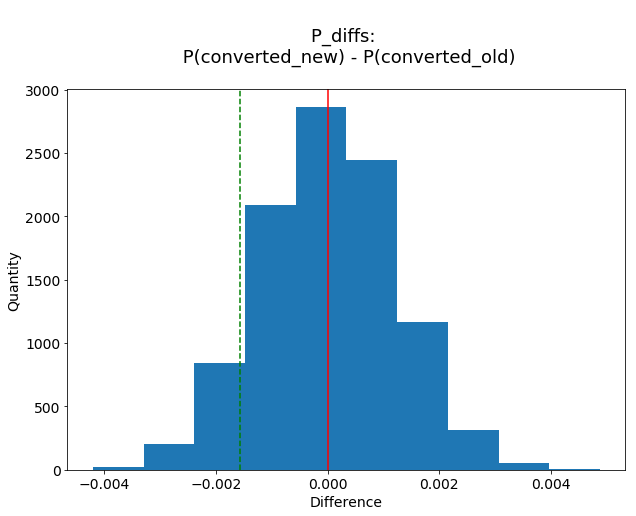

In [27]:
null_diff = 0 # As per Null Hypothesis there is no difference on converted rate between old and new page. ACtually,
              #  null states new_page <= old_page but 0 value is the closest value to the alternative within the null. 

plt.figure(figsize=(10,7));
plt.title("\nP_diffs: \n P(converted_new) - P(converted_old)\n", fontsize=18);
plt.xlabel("Difference", fontsize=14);
plt.ylabel("Quantity", fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.hist(p_diffs);
plt.axvline(x=null_diff, color="red");
plt.axvline(x=obs_diff, color = 'green', linestyle='--');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diff).mean()

0.9087

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**p-value was computed in j. <p>
    The p-value is the probability of a value, in this case, the observed difference between people who converted when having the new page and people who converted when having the old one, when assuming the null hypothesis to be true. <p>
    Something like: <p>
        $$ P( P(converting\ |\ new\_page)\ -\ P(converting\ |\ old\_page))\ $$ <p>
    assuming: <p>
        $$H_0:\ p_{new} \leq \ p_{old}$$ <p>
    A smaller p-value than the established threshold for Type I errors, in this case 0.05, means it's less likely to observe this statistic from the null and we need to reject $H_0$. On the contrary, when p-value is bigger this means the statistic probably comes from the null and we fail to reject $H_0$. <p>
    In our example, a p-value of 0.9085, is indeed greated than the 0.05 established $\alpha$, that is, in our case we fail to reject the null hypothesis. 
    **

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"').shape[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').shape[0]
# The number of rows associated with the old page and new pages, respectively, was already computed in 2 C
#n_old =
#n_new = 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score , p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Just as when assessing a p-value we need to know what type I error threshold we accept, that is, $\alpha$'s value, we need to know that too when checking a z_score. <p>
    As in our case $\alpha = 0.5$, we can establish a significance level of 95%. As we are checking for `p_diffs`'s values larger than `obs_diff` , a z-score greater than -1.96 will be significant. Which in this case, is. <p>
    p-value computed by `sm.stats.proportions_ztest` it's similar to the one computed in j. This is why, both from the p-value and the z_score we can conclude that the null can't be rejected. <p>
        **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we need to predict between just two categorical outcomes, conversion or not conversion, logistic regression needs to be used. **

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1

In [32]:
df2[['ab_page','old_page']] = pd.get_dummies(df[['landing_page']])
df2.drop('old_page', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        02:19:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**The p-value associated with ab_page is 0.190. <p>
    It differs from the found values since Part II's $H_0$ and $H_a$ were: <p>
        **$$H_0:\ p_{new} \leq \ p_{old}$$
$$H_{a}:\ p_{new} > \ p_{old}$$ <p>
**However, the regression model is working with the assumption that $p_{new}$ and $p_{old}$ are the same. That is: **<p>
    $$H_0:\ p_{new} = \ p_{old}$$
$$H_{a}:\ p_{new} \neq \ p_{old}$$ <p>
**This can be confirmed by, either manually calculating p-value or calculating it through `proportions_ztest` method.  **

In [35]:
(p_diffs < obs_diff).mean() + (p_diffs > p_diffs.mean() + (p_diffs.mean() - obs_diff)).mean()

0.1816

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='two-sided')
z_score , p_value

(-1.3109241984234394, 0.18988337448195103)

**It can be seen than manual calculation for double sided alternative hypothesis shows a very similar value to 0.191.<p>
    The same can be seen with `proportions_ztest` p-value of 0.189.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

   **Considering other factors such as age, price for enrolling (this could be discarded if free),if it's a course, its duration, could sometimes be useful to understand what variable can be changed, and how, to improve convertion. However, when using multiple linear regression a special attention needs to be put to avoid five common problems.**
1. **Linear regression not existing**
If a linear regression is not present is better to use a non-linear model since accuracy can be reduced. 
1. **Correlated Errors**
>"If in fact there is correlation among the error terms, then the estimated standard errors will tend to underestimate the true standard errors. As a result, confidence and prediction intervals will be narrower than they should be. (...)In addition, p-values associated with the model will be lower than they should be; this could cause us to erroneously conclude that a parameter is statistically significant. In short, if the error terms are correlated, we may have an unwarranted sense of confidence in our model." (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, *An Introduction to Statistical Learning*, p.94)
1. **Non-Constant variance**
This can generate confidence intervals and p-values that are inaccurate. 
1. **Outliers**
>"If we believe that an outlier has occurred due to an error in data collection or recording, then one solution is to simply remove the observation.However, care should be taken, since an outlier may instead indicate a deficiency with the model, such as a missing predictor" (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, *An Introduction to Statistical Learning*, p.97)
1. **Multicolinearity**
The X variables should only be correlated with the response but not to one another. If this is the case, coefficients may be flipped from the direction we expect from simple linear regression.

**Another factor that would be good to include is if user is new to the platform or already an existing user. Since both change aversion and novelty effect may influence existing users. **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1


In [38]:
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [39]:
df_new[['country_CA', 'country_UK', 'country_US']] = pd.get_dummies(df_new['country'])
df_new.drop('country', axis=1)
#I choose not to drop one of the country columns. Instead, I won't include it when generating the model.
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,country_CA,country_UK,country_US
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1


In [40]:
df_new.shape[0] == unique_users_count

True

In [41]:
converted_CA = df_new.query("converted==1 and country_CA==1")
converted_CA_count = converted_CA.shape[0]
p_converted_CA = converted_CA_count / unique_users_count
p_converted_CA

0.005753930016793767

In [42]:
converted_UK = df_new.query("converted==1 and country_UK==1")
converted_UK_count = converted_UK.shape[0]
p_converted_UK = converted_UK_count / unique_users_count
p_converted_UK

0.03007392010571814

In [43]:
converted_US = df_new.query("converted==1 and country_US==1")
converted_US_count = converted_US.shape[0]
p_converted_US = converted_US_count / unique_users_count
p_converted_US

0.08376923712248438

In [44]:
logit_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'country_CA', 'country_UK']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 21 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        02:19:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
country_CA    -0.0408      0.027     -1.516      0.130      -0.093       0.012
country_UK     0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [45]:
#Reciprocals
intercept = 1/np.exp(-1.9893)
intercept

7.310414680563591

In [46]:
ab_page = 1/np.exp(-0.0149)
ab_page

1.0150115583846535

In [47]:
country_CA = 1/np.exp(-0.0408)
country_CA

1.0416437559600236

In [48]:
country_UK = 1/np.exp(0.0099)
country_UK

0.9901488436829571

**It seems that for people in Canada, converting is 1.042 times less likely than for people in the US (US was chosen as baseline) holding all else is constant. <p>
For people in the UK, converting is 0.99 times less likely than for people in the US holding all else is constant.      <p>
From the model it can also bee seen that for people recieving the new page, converting is 1.015 times less likely than for people recieving the old one, holding all else is constant.<p>
This model results match in order of likeliness of converting with the results from manual calculations since from the model it apears that convertion order is US, UK and lastly Canada and so can be seen from calculated values US (probability of converting=0.0837), UK (probability of converting=0.0300) and last, Canada (probability of converting=0.0057).<p><p>
    By taking a look at the p values it seems that country has no statistical significance though it can be argued that there can be a practical significance in evaluating countries convertion so to know what countries should be targeted with more publicity, etc.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
lm = sm.OLS(df_new['converted'], df_new[['intercept', 'ab_page', 'country_CA', 'country_UK']])
results3 = lm.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sun, 21 Oct 2018   Prob (F-statistic):              0.178
Time:                        02:19:56   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1203      0.001    128.267      0.000       0.118       0.122
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
country_CA    -0.0042      0.003     -1.514      0.130      -0.010       0.001
country_UK     0.0010      0.001      0.744      0.457      -0.002       0.004
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         5.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='conclusions'></a>
## Conclusions

**In conclusion, it can be said that I fail to reject $H_0$. <p>
    Apart from the sample showing a bearly smaller than 1 value (-0.00157) for $p_{new}- p_{old}$, when simulating 10,000 $p_{new}$ - $p_{old}$ values, same thing happend.<p>
All p-values calculations showed values greater than the established threshold of 0.05. <p>
    All regression tests showed p-values greater than 0.05 for the different variables implying that there is not much statistical significance in recieving new or old page, or from which country the people are for converting. This makes some sense since, for example, the probability of converting is 0.1196, probability of converting when recieving new page is 0.1188 and the probability of converting when recieving the old page is 0.1203, it can be seen than there is practically no difference in this values. 
    The same happens with countries where, though there is a little bit more difference, it's pretty small. For example, the probability of converting for people from Canada is 0.005, the probability of converting for people from teh UK is 0.030 and the probability of converting for people of the US is 0.837.**